# ZapLineを用いたLFPに対する電源由来のアーティファクト除去 (Python)

## ZapLineとは
ZapLineはEEGやMEGなどのデータにおける**電力系統 (power line)に由来するアーティファクトを除去**するアルゴリズムである．アーティファクトの周波数を指定し（残念ながら指定が必要），アーティファクト成分のみを除去する時空間的フィルタを求めることを目的とする．やや手法が込み入っていたので詳細は論文のmethodを読んでほしい．

ZapLineの論文：
> [Cheveigné, Alain de. 2020. “ZapLine: A Simple and Effective Method to Remove Power Line Artifacts.” *NeuroImage*](https://www.sciencedirect.com/science/article/pii/S1053811919309474). 


## meegkitでZapLineを使用する
ZapLineはMATLABでの実装が著者により公開されている．
- http://audition.ens.fr/adc/NoiseTools/src/NoiseTools/EXAMPLES/zapline/
- https://github.com/MariusKlug/zapline-plus

この記事では`meegkit`というPythonライブラリにおける実装を使用する．documentとgithubへのリンクは次の通り：
- doc: https://nbara.github.io/python-meegkit/index.html
- github: https://github.com/nbara/python-meegkit


### 必要なライブラリのinstall
pipにより，`pyedflib`, `pyriemann`, `meegkit`をinstallする．

```shell
pip install pyedflib
pip install pyriemann
pip install git+https://github.com/nbara/python-meegkit.git
```

[`pyedflib`](https://pyedflib.readthedocs.io/en/latest/)は.bdfファイルを読み込むために使用する．`pyriemann`は`meegkit`で使用されており，別途installが必要となった．

### ライブラリのimport
以下では`meegkit`の[example](https://nbara.github.io/python-meegkit/auto_examples/example_dss_line.html#sphx-glr-auto-examples-example-dss-line-py)を参考にしてZapLineの使用法を見ていく．まずライブラリをimportする．

In [1]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
plt.rcParams.update({'axes.spines.top': False, 'axes.spines.right': False})

from meegkit import dss
from meegkit.utils import unfold
from meegkit.utils.denoise import demean

import pyedflib

### データのdownload
解析に使用するデータをdownloadする．[著者実装](http://audition.ens.fr/adc/NoiseTools/src/NoiseTools/EXAMPLES/zapline/)で使用されていた`EEG_Cat_Study4_Resting_S1.bdf`を[Raw Empirical EEG Data - Trujillo et al. (2017) Frontiers in Neuroscience](https://dataverse.tdl.org/dataset.xhtml?persistentId=doi:10.18738/T8/ANS9Q1)のページでDownloadする．

あるいは[example](https://nbara.github.io/python-meegkit/auto_examples/example_dss_line.html#sphx-glr-auto-examples-example-dss-line-py)のように[`dss_line_data.npy`](https://github.com/nbara/python-meegkit/blob/master/tests/data/dss_line_data.npy)を使用してもよい．

In [2]:
file = pyedflib.EdfReader("EEG_Cat_Study4_Resting_S1.bdf")

bdfファイルを読み込む．メソッドの詳細は[`pyedflib`](https://pyedflib.readthedocs.io/en/latest/)を参照．

In [3]:
n = file.signals_in_file # 73
signal_labels = file.getSignalLabels() # len(signal_labels): 73

sigbufs = np.zeros((n, file.getNSamples()[0])) # sigbufs.shape: (73, 130560)
for i in np.arange(n):
    sigbufs[i, :] = file.readSignal(i)

#header = file.getSignalHeaders()
sfreq = file.getSampleFrequencies()[0] # sample frequency

データの一部だけをsliceし，[`demean`](https://nbara.github.io/python-meegkit/modules/meegkit.utils.html#module-meegkit.utils.denoise)関数でcenteringする．

In [4]:
X = sigbufs[:67, :20000]
X = demean(X.T)

パワースペクトル密度 (power spectral density; PSD)を[`scipy.signal.welch`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html)で推定する．

In [5]:
freq, Pxx = signal.welch(unfold(X), sfreq, nperseg=500, axis=0, 
                         return_onesided=True)

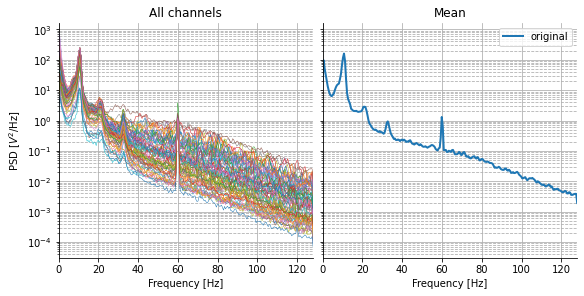

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4),
                       sharey=True, constrained_layout=True)
ax[0].semilogy(freq, Pxx, lw=.5)
ax[0].set_title('All channels')
ax[0].set_xlabel('Frequency [Hz]')
ax[0].set_ylabel(r'PSD [$V^2$/Hz]')
ax[0].grid(True, which="major")
ax[0].grid(True, which="minor", linestyle='dashed')
ax[0].set_xlim(freq[0], freq[-1])

ax[1].semilogy(freq, Pxx.mean(1), lw=2, label="original")
ax[1].set_title('Mean')
ax[1].set_xlabel('Frequency [Hz]')
ax[1].grid(True, which="major")
ax[1].grid(True, which="minor", linestyle='dashed')
ax[1].set_xlim(freq[0], freq[-1])
ax[1].legend()
plt.show()

左が使用したチャネルのPSDであり，右はその平均である．60Hz付近に電源に由来するアーティファクトが見える．これがアーティファクトと言える理由は60Hz丁度にあり，ピーク幅が狭いなどが挙げられる．これを除く方法を次節で紹介する．

### ZapLineの実行
交流電力の周波数は50Hz or 60Hzなのでいずれかを指定してZapLineを実行する．もちろんこれ以外の周波数も除去できる．

In [7]:
fline = 60 # line frequency

# Apply dss_line (ZapLine)
out, _ = dss.dss_line(X, fline, sfreq, nremove=3, nfft=1024)

Power of components removed by DSS: 0.00


`nremove`は除去アルゴリズムを実行する回数であり，収束するまで実行する[`dss.dss_line_iter`](https://nbara.github.io/python-meegkit/modules/meegkit.dss.html?highlight=dss%20dss_line_iter#meegkit.dss.dss_line_iter)関数もある．ただ収束しない場合もあるので，そうした場合には[`dss.dss_line`](https://nbara.github.io/python-meegkit/modules/meegkit.dss.html#meegkit.dss.dss_line)を使用する．

結果を描画する．

In [8]:
freq, Pxx_out = signal.welch(unfold(out), sfreq, nperseg=500, axis=0, 
                             return_onesided=True)

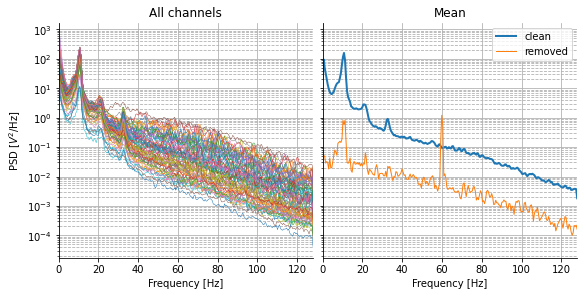

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4), 
                       sharey=True, constrained_layout=True)
ax[0].semilogy(freq, Pxx_out, lw=.5)
ax[0].set_title('All channels')
ax[0].set_xlabel('Frequency [Hz]')
ax[0].set_ylabel(r'PSD [$V^2$/Hz]')
ax[0].grid(True, which="major")
ax[0].grid(True, which="minor", linestyle='dashed')
ax[0].set_xlim(freq[0], freq[-1])

ax[1].semilogy(freq, Pxx_out.mean(1), lw=2, label="clean")
ax[1].semilogy(freq, np.abs(Pxx - Pxx_out).mean(1), lw=1, 
               label="removed")
ax[1].set_title('Mean')
ax[1].set_xlabel('Frequency [Hz]')
ax[1].grid(True, which="major")
ax[1].grid(True, which="minor", linestyle='dashed')
ax[1].set_xlim(freq[0], freq[-1])
ax[1].legend()
plt.show()

左がZapLineを適応した全チャネルのPSDであり，右は青がその平均，オレンジは元データとの差分の絶対値である．一つ上の図と見比べると，概ねアーティファクト成分のみを除けていることがわかる．